In [ ]:
# Cài đặt thư viện tensorflow
!pip install tensorflow

In [ ]:
# Import các thư viện cần thiết cho quá trình train
import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout


In [ ]:
# Kết nối google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras.callbacks import (
    Callback,
    CSVLogger,
    EarlyStopping,
    LearningRateScheduler,
    ModelCheckpoint
)

In [ ]:
print("TensorFlow version:", tf.__version__)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU is available:", gpus)
else:
    print("GPU is NOT available")

TensorFlow version: 2.18.0
GPU is available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# Thực hiện chia dữ liệu giữa train và val
original_dataset_dir = '/content/drive/MyDrive/DACNTTNT/Brain Tumor MRI Dataset'
output_base_dir = '/content/drive/MyDrive/DACNTTNT/Brain_Tumor_Split'
split_ratio = 0.2 # 20% cho tập validation

# Kiểm tra xem tập dữ liệu đã chia chưa, nếu chia rồi thì bỏ qua
if not os.path.exists(os.path.join(output_base_dir, 'train')):
    for class_name in os.listdir(original_dataset_dir):
        class_path = os.path.join(original_dataset_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        images = os.listdir(class_path)
        random.shuffle(images)
        val_count = int(len(images) * split_ratio)

        train_class_dir = os.path.join(output_base_dir, 'train', class_name)
        val_class_dir = os.path.join(output_base_dir, 'val', class_name)
        os.makedirs(train_class_dir, exist_ok=True)
        os.makedirs(val_class_dir, exist_ok=True)

        for i, img_name in enumerate(images):
            src_path = os.path.join(class_path, img_name)
            dst_path = os.path.join(val_class_dir if i < val_count else train_class_dir, img_name)
            shutil.copy2(src_path, dst_path)

    print("Đã chia dữ liệu train/val tại:", output_base_dir)
else:
    print("Dữ liệu đã được chia trước đó, không cần chia lại.")

Dữ liệu đã được chia trước đó, không cần chia lại.


In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input

datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    fill_mode='nearest'
)

data_path = '/content/drive/MyDrive/DACNTTNT/Brain Tumor MRI Dataset'

# Train generator (80%)
train_generator = datagen.flow_from_directory(
    data_path,
    subset='training',
    batch_size=32,
    class_mode='categorical',
    target_size=(256, 256),
    shuffle=True
)

# Validation generator (20%)
validation_generator = datagen.flow_from_directory(
    data_path,
    subset='validation',
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    target_size=(256, 256)
)


Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.


Class Names: ['glioma', 'meningioma', 'notumor', 'pituitary']


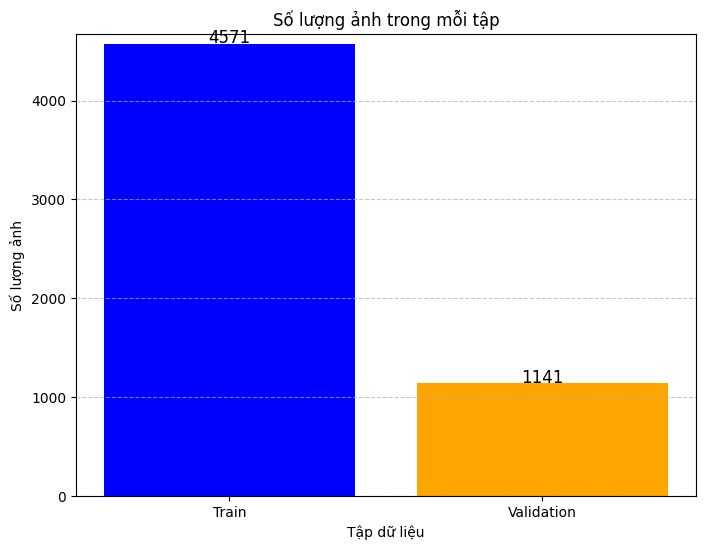

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Lấy tên lớp
class_names = list(train_generator.class_indices.keys())
print("Class Names:", class_names)

# Số lượng ảnh trong từng tập train/val
train_size = train_generator.samples
val_size = validation_generator.samples

# Biểu đồ tổng quan
dataset_sizes = [train_size, val_size]
dataset_labels = ['Train', 'Validation']

plt.figure(figsize=(8, 6))
bars = plt.bar(dataset_labels, dataset_sizes, color=['blue', 'orange'])

# Thêm số lên cột
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 10, str(yval), ha='center', fontsize=12)

plt.title('Số lượng ảnh trong mỗi tập')
plt.xlabel('Tập dữ liệu')
plt.ylabel('Số lượng ảnh')
plt.ylim(0, max(dataset_sizes) + 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


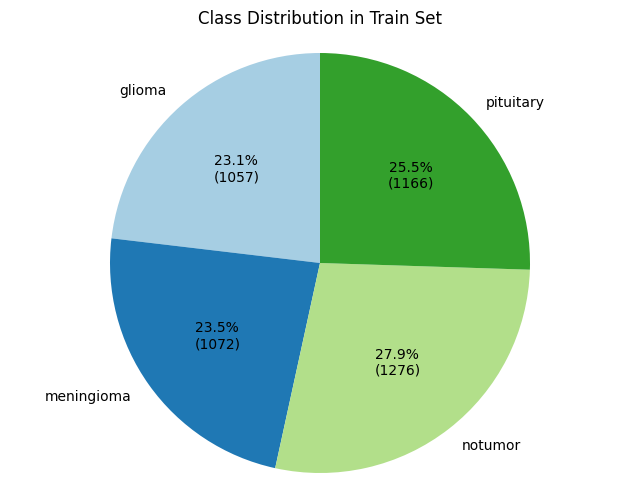

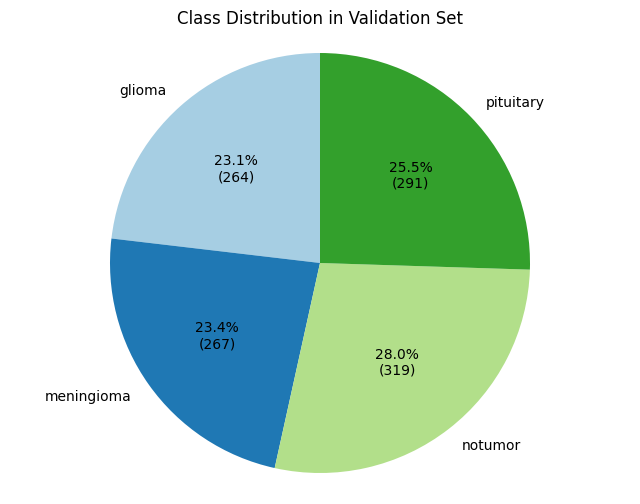

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_class_distribution_pie(generator, generator_name):
    labels = generator.classes
    class_counts = np.bincount(labels)

    def autopct_format(pct, all_vals):
        absolute = int(round(pct/100.*np.sum(all_vals)))
        return f"{pct:.1f}%\n({absolute})"

    plt.figure(figsize=(8, 6))
    plt.pie(class_counts, labels=class_names,
            autopct=lambda pct: autopct_format(pct, class_counts),
            startangle=90,
            colors=plt.cm.Paired.colors[:len(class_names)])
    plt.title(f'Class Distribution in {generator_name} Set')
    plt.axis('equal')
    plt.show()

# Vẽ biểu đồ phân bố lớp
plot_class_distribution_pie(train_generator, 'Train')
plot_class_distribution_pie(validation_generator, 'Validation')


In [ ]:
train_dir = '/content/drive/MyDrive/DACNTTNT/Brain_Tumor_Split/train'
class_names = sorted([
    d for d in os.listdir(train_dir)
    if os.path.isdir(os.path.join(train_dir, d))
])
num_classes = len(class_names)
print("Class Names:", class_names)
print("Number of Classes:", num_classes)

Class Names: ['glioma', 'meningioma', 'notumor', 'pituitary']
Number of Classes: 4


In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import os, random

def visualize_images(path, target_size=(256, 256), num_images=5):
    image_filenames = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
    if not image_filenames:
        raise ValueError("No images found in the specified path")

    selected_images = random.sample(image_filenames, min(num_images, len(image_filenames)))
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3), facecolor='white')

    for i, image_filename in enumerate(selected_images):
        image_path = os.path.join(path, image_filename)
        try:
            image = Image.open(image_path).convert('RGB')
            image = image.resize(target_size)
            axes[i].imshow(image)
            axes[i].axis('off')
            axes[i].set_title(f"{os.path.basename(path)}\n{image_filename}")
        except Exception as e:
            axes[i].set_title("Error")
            axes[i].axis('off')

    plt.tight_layout()
    plt.show()

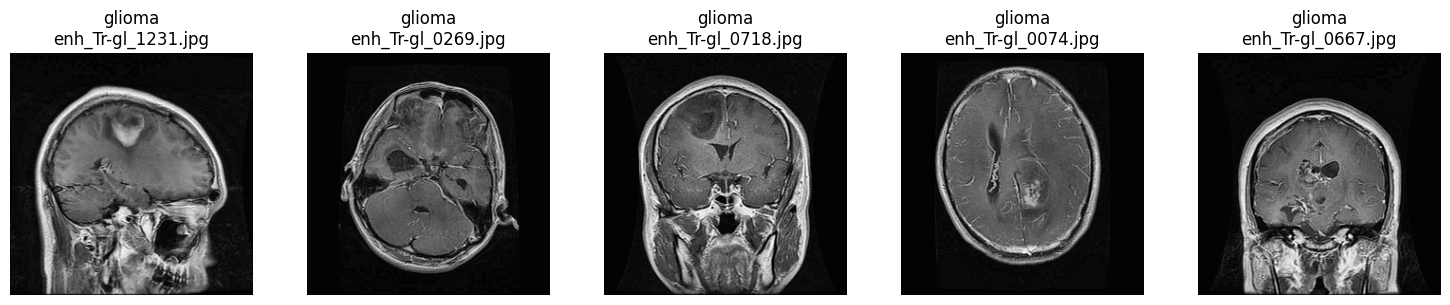

In [ ]:
# Specify the path containing the images to visualize
path_to_visualize = "/content/drive/MyDrive/DACNTTNT/Brain_Tumor_Split/train/glioma"
# Visualize 5 random images
visualize_images(path_to_visualize, num_images=5)

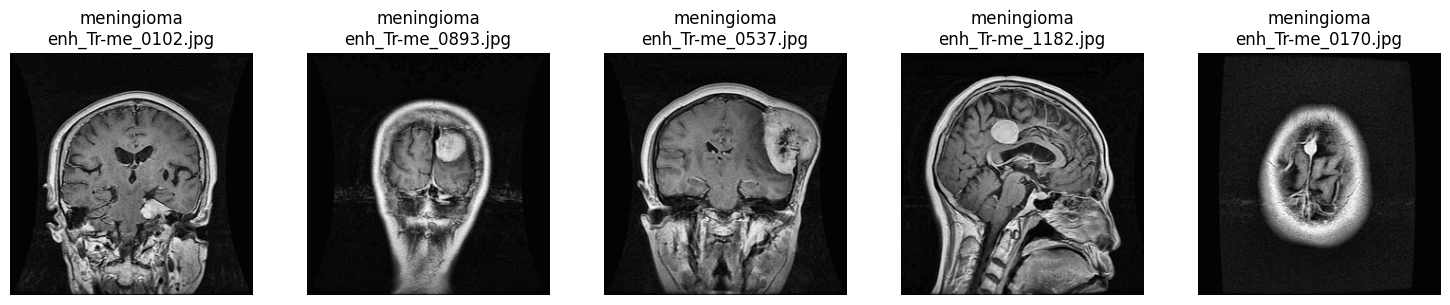

In [ ]:
# Specify the path containing the images to visualize
path_to_visualize = "/content/drive/MyDrive/DACNTTNT/Brain_Tumor_Split/train/meningioma"
# Visualize 5 random images
visualize_images(path_to_visualize, num_images=5)

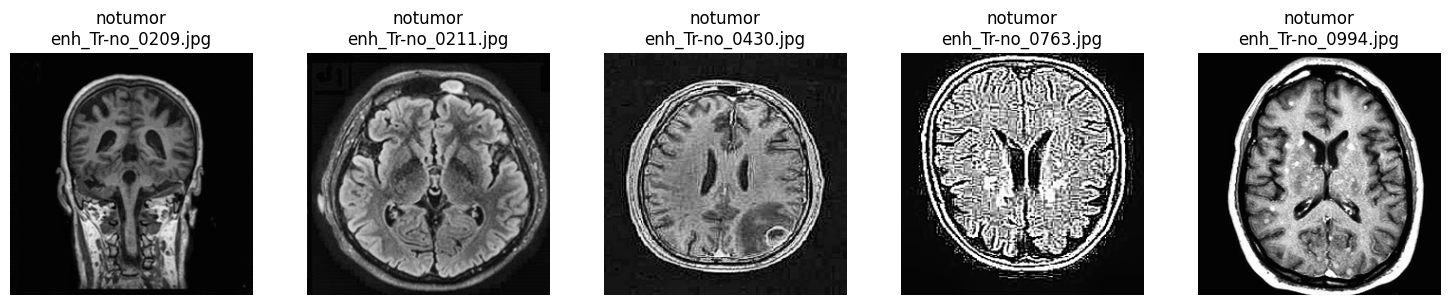

In [ ]:
# Specify the path containing the images to visualize
path_to_visualize = "/content/drive/MyDrive/DACNTTNT/Brain_Tumor_Split/train/notumor"
# Visualize 5 random images
visualize_images(path_to_visualize, num_images=5)

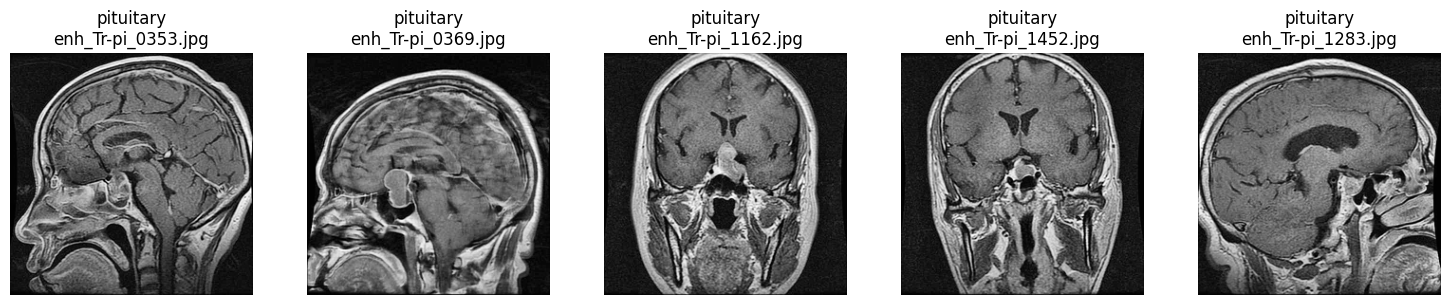

In [ ]:
# Specify the path containing the images to visualize
path_to_visualize = "/content/drive/MyDrive/DACNTTNT/Brain_Tumor_Split/train/pituitary"
# Visualize 5 random images
visualize_images(path_to_visualize, num_images=5)

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, Model, regularizers

# Khởi tạo mô hình ResNet50 không có phần top
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Đóng băng các tầng ResNet để giữ lại trọng số đã học
for layer in base_model.layers:
    layer.trainable = False

# Xây head phân loại
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = layers.Dropout(0.3)(x)
predictions = layers.Dense(4, activation='softmax', kernel_regularizer=regularizers.l2(0.001))(x)

# Kết nối vào model hoàn chỉnh
model = Model(inputs=base_model.input, outputs=predictions)

# Hiển thị kiến trúc
model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 24,113,284 (91.98 MB)

 Trainable params: 525,572 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# Compile cho mô hình
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import Adam

for layer in base_model.layers:
    layer.trainable = False

# Compile mô hình sau khi đã freeze
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Thiết lập callback
checkpoint_callback = ModelCheckpoint(
    '/content/drive/MyDrive/DACNTTNT/project/results/best_resnet50.h5',
    monitor='val_accuracy',
    mode='max',
    verbose=1,
    save_best_only=True
)

early_stopping_callback = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

csv_logger_callback = CSVLogger(
    '/content/drive/MyDrive/DACNTTNT/project/results/training_history.csv',
    append=True
)

# Tổng hợp callback để sử dụng trong model.fit
callbacks = [checkpoint_callback, early_stopping_callback, csv_logger_callback]


In [ ]:
# Train the model
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=callbacks,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 27s/step - accuracy: 0.5309 - loss: 1.6293 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_accuracy improved from -inf to 0.76775, saving model to /content/drive/MyDrive/DACNTTNT/project/results/best_resnet50.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 4828s 34s/step - accuracy: 0.5319 - loss: 1.6268 - val_accuracy: 0.7677 - val_loss: 1.1421
Epoch 2/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 742ms/step - accuracy: 0.8425 - loss: 0.8931
Epoch 2: val_accuracy did not improve from 0.76775
143/143 ━━━━━━━━━━━━━━━━━━━━ 149s 1s/step - accuracy: 0.8425 - loss: 0.8930 - val_accuracy: 0.7599 - val_loss: 1.0823
Epoch 3/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 739ms/step - accuracy: 0.8526 - loss: 0.8253
Epoch 3: val_accuracy improved from 0.76775 to 0.80105, saving model to /content/drive/MyDrive/DACNTTNT/project/results/best_resnet50.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 135s 945ms/step - accuracy: 0.8527 - loss: 0.8252 - val_accuracy: 0.8011 - val_loss: 0.9508
Epoch 4/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 755ms/step - accuracy: 0.8799 - loss: 0.7414
Epoch 4: val_accuracy improved from 0.80105 to 0.82121, saving model to /content/drive/MyDrive/DACNTTNT/project/results/best_resnet50.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 138s 965ms/step - accuracy: 0.8799 - loss: 0.7413 - val_accuracy: 0.8212 - val_loss: 0.8738
Epoch 5/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 739ms/step - accuracy: 0.8814 - loss: 0.7278
Epoch 5: val_accuracy did not improve from 0.82121
143/143 ━━━━━━━━━━━━━━━━━━━━ 132s 923ms/step - accuracy: 0.8815 - loss: 0.7277 - val_accuracy: 0.8098 - val_loss: 0.8933
Epoch 6/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 732ms/step - accuracy: 0.8872 - loss: 0.6779
Epoch 6: val_accuracy improved from 0.82121 to 0.82559, saving model to /content/drive/MyDrive/DACNTTNT/project/results/best_resnet50.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 135s 946ms/step - accuracy: 0.8872 - loss: 0.6780 - val_accuracy: 0.8256 - val_loss: 0.8497
Epoch 7/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 751ms/step - accuracy: 0.8903 - loss: 0.6587
Epoch 7: val_accuracy did not improve from 0.82559
143/143 ━━━━━━━━━━━━━━━━━━━━ 134s 939ms/step - accuracy: 0.8903 - loss: 0.6586 - val_accuracy: 0.8054 - val_loss: 0.8370
Epoch 8/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 746ms/step - accuracy: 0.8913 - loss: 0.6425
Epoch 8: val_accuracy improved from 0.82559 to 0.83961, saving model to /content/drive/MyDrive/DACNTTNT/project/results/best_resnet50.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 139s 972ms/step - accuracy: 0.8913 - loss: 0.6424 - val_accuracy: 0.8396 - val_loss: 0.7998
Epoch 9/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 735ms/step - accuracy: 0.8993 - loss: 0.6157
Epoch 9: val_accuracy improved from 0.83961 to 0.84224, saving model to /content/drive/MyDrive/DACNTTNT/project/results/best_resnet50.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 134s 938ms/step - accuracy: 0.8993 - loss: 0.6157 - val_accuracy: 0.8422 - val_loss: 0.7691
Epoch 10/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 755ms/step - accuracy: 0.9084 - loss: 0.5967
Epoch 10: val_accuracy improved from 0.84224 to 0.85276, saving model to /content/drive/MyDrive/DACNTTNT/project/results/best_resnet50.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 138s 963ms/step - accuracy: 0.9084 - loss: 0.5966 - val_accuracy: 0.8528 - val_loss: 0.7375
Epoch 11/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 750ms/step - accuracy: 0.9087 - loss: 0.5792
Epoch 11: val_accuracy improved from 0.85276 to 0.85451, saving model to /content/drive/MyDrive/DACNTTNT/project/results/best_resnet50.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 137s 956ms/step - accuracy: 0.9087 - loss: 0.5792 - val_accuracy: 0.8545 - val_loss: 0.7481
Epoch 12/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 757ms/step - accuracy: 0.9124 - loss: 0.5633
Epoch 12: val_accuracy did not improve from 0.85451
143/143 ━━━━━━━━━━━━━━━━━━━━ 135s 946ms/step - accuracy: 0.9124 - loss: 0.5633 - val_accuracy: 0.8379 - val_loss: 0.7508
Epoch 13/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 752ms/step - accuracy: 0.9133 - loss: 0.5414
Epoch 13: val_accuracy improved from 0.85451 to 0.86591, saving model to /content/drive/MyDrive/DACNTTNT/project/results/best_resnet50.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 137s 962ms/step - accuracy: 0.9133 - loss: 0.5414 - val_accuracy: 0.8659 - val_loss: 0.6658
Epoch 14/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 739ms/step - accuracy: 0.9183 - loss: 0.5298
Epoch 14: val_accuracy did not improve from 0.86591
143/143 ━━━━━━━━━━━━━━━━━━━━ 132s 924ms/step - accuracy: 0.9183 - loss: 0.5298 - val_accuracy: 0.8528 - val_loss: 0.7061
Epoch 15/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 736ms/step - accuracy: 0.9187 - loss: 0.5135
Epoch 15: val_accuracy did not improve from 0.86591
143/143 ━━━━━━━━━━━━━━━━━━━━ 132s 922ms/step - accuracy: 0.9187 - loss: 0.5135 - val_accuracy: 0.8554 - val_loss: 0.6786
Epoch 16/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 738ms/step - accuracy: 0.9240 - loss: 0.5016
Epoch 16: val_accuracy did not improve from 0.86591
143/143 ━━━━━━━━━━━━━━━━━━━━ 132s 924ms/step - accuracy: 0.9240 - loss: 0.5017 - val_accuracy: 0.8606 - val_loss: 0.6781
Epoch 17/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 736ms/step - accuracy: 0.9245 - loss: 0.4950
Epoc

143/143 ━━━━━━━━━━━━━━━━━━━━ 134s 942ms/step - accuracy: 0.9244 - loss: 0.4951 - val_accuracy: 0.8957 - val_loss: 0.6119
Epoch 18/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 757ms/step - accuracy: 0.9229 - loss: 0.4894
Epoch 18: val_accuracy did not improve from 0.89571
143/143 ━━━━━━━━━━━━━━━━━━━━ 142s 945ms/step - accuracy: 0.9229 - loss: 0.4893 - val_accuracy: 0.8826 - val_loss: 0.6144
Epoch 19/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 758ms/step - accuracy: 0.9222 - loss: 0.4846
Epoch 19: val_accuracy did not improve from 0.89571
143/143 ━━━━━━━━━━━━━━━━━━━━ 136s 950ms/step - accuracy: 0.9222 - loss: 0.4846 - val_accuracy: 0.8519 - val_loss: 0.6446
Epoch 20/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 752ms/step - accuracy: 0.9218 - loss: 0.4777
Epoch 20: val_accuracy did not improve from 0.89571
143/143 ━━━━━━━━━━━━━━━━━━━━ 134s 939ms/step - accuracy: 0.9218 - loss: 0.4777 - val_accuracy: 0.8712 - val_loss: 0.6102
Epoch 21/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 746ms/step - accuracy: 0.9250 - loss: 0.4574
Epoc

In [ ]:
model.save('/content/drive/MyDrive/DACNTTNT/project/results/best_resnet50.h5')

In [ ]:
from tensorflow.keras.models import load_model

model_path = '/content/drive/MyDrive/DACNTTNT/project/results/best_resnet50.h5'
model = load_model(model_path)

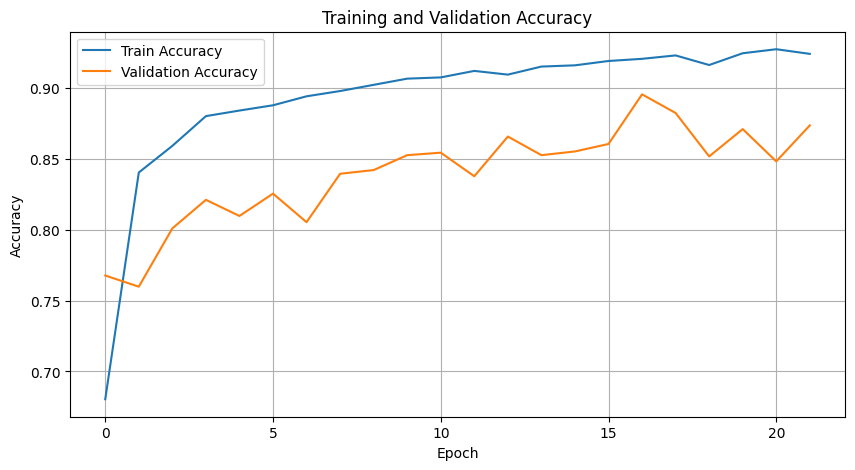

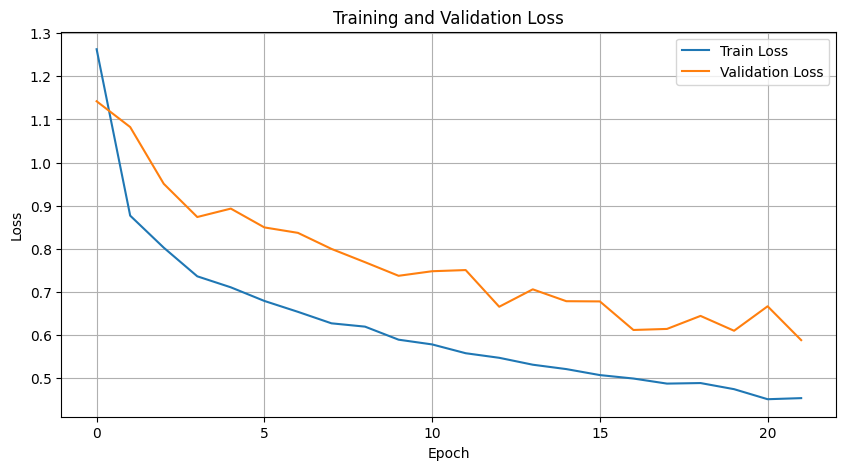

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Đọc file CSV chứa lịch sử huấn luyện
history_df = pd.read_csv('/content/drive/MyDrive/DACNTTNT/project/results/training_history.csv')

# Vẽ biểu đồ Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history_df['accuracy'], label='Train Accuracy')
plt.plot(history_df['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('/content/drive/MyDrive/DACNTTNT/project/results/accuracy_plot.webp', format='webp')
plt.show()

# Vẽ biểu đồ Loss
plt.figure(figsize=(10, 5))
plt.plot(history_df['loss'], label='Train Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('/content/drive/MyDrive/DACNTTNT/project/results/loss_plot.webp', format='webp')
plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


36/36 ━━━━━━━━━━━━━━━━━━━━ 993s 28s/step


<Figure size 1000x800 with 0 Axes>

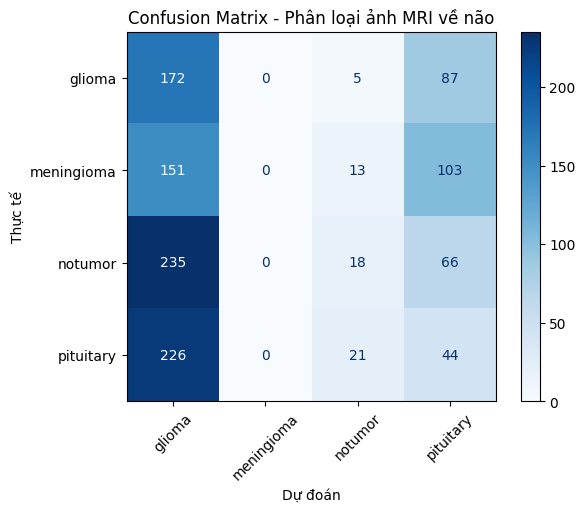

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred_probs = model.predict(validation_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

y_true = validation_generator.classes

class_names = list(validation_generator.class_indices.keys())

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
plt.figure(figsize=(10, 8))
disp.plot(cmap='Blues', values_format='d')
plt.xticks(rotation=45)
plt.title('Confusion Matrix - Phân loại ảnh MRI về não')
plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.show()

In [ ]:
from PIL import Image

validation_img_paths = ["/content/drive/MyDrive/DACNTTNT/Brain_Tumor_Split/train/glioma/enh_Tr-glTr_0006.jpg",
                        "/content/drive/MyDrive/DACNTTNT/Brain_Tumor_Split/train/meningioma/enh_Tr-meTr_0009.jpg",
                        "/content/drive/MyDrive/DACNTTNT/Brain_Tumor_Split/train/notumor/enh_Tr-noTr_0008.jpg",
                        "/content/drive/MyDrive/DACNTTNT/Brain_Tumor_Split/train/pituitary/enh_Tr-piTr_0008.jpg",
                        "/content/drive/MyDrive/DACNTTNT/Brain_Tumor_Split/val/meningioma/enh_Tr-me_0012.jpg",
                        "/content/drive/MyDrive/DACNTTNT/Brain_Tumor_Split/val/glioma/enh_Tr-glTr_0000.jpg"]
img_list = [Image.open(img_path) for img_path in validation_img_paths]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


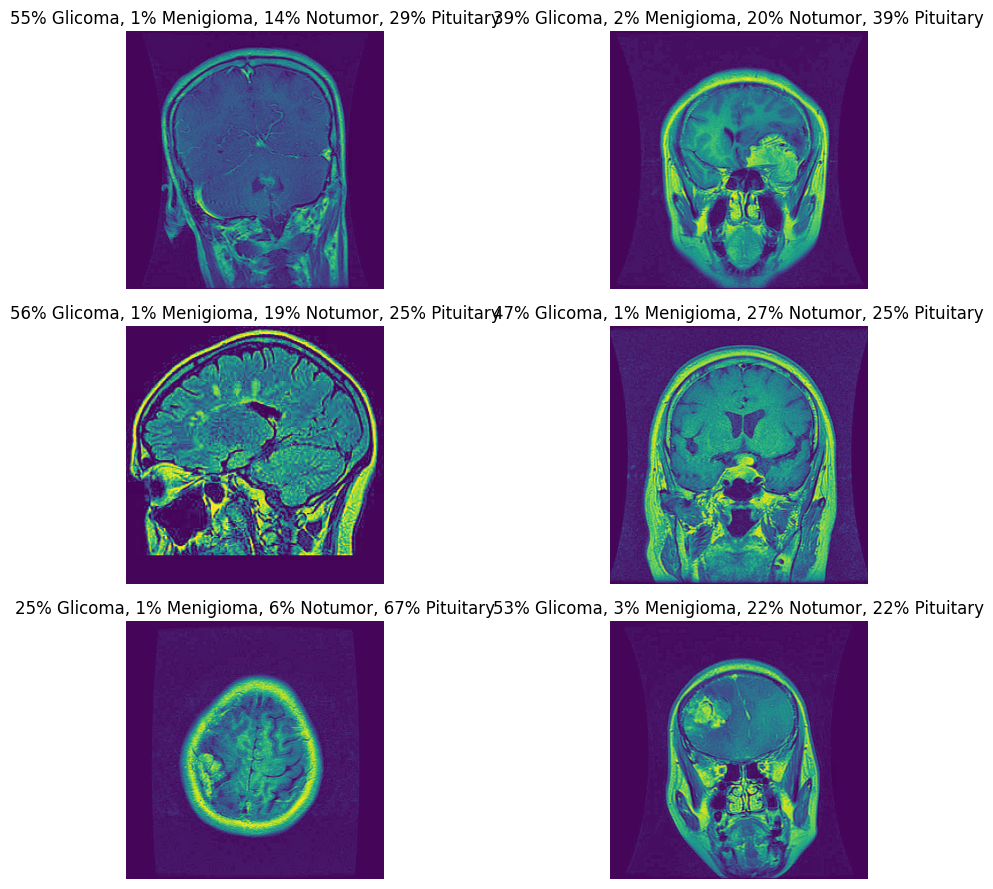

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import preprocess_input

# Resize ảnh, chuyển sang RGB, đưa vào batch
validation_batch = np.stack([
    preprocess_input(np.array(img.convert("RGB").resize((256, 256))))
    for img in img_list
])

# Dự đoán
pre_prob = model.predict(validation_batch)

# Vẽ ảnh và xác suất dự đoán
fig, axs = plt.subplots(3, 2, figsize=(12, 9))
axs = axs.flatten()
for i, img in enumerate(img_list):
  ax = axs[i]
  ax.axis('off')
  ax.set_title(
      "{:.0f}% Glicoma, {:.0f}% Menigioma, {:.0f}% Notumor, {:.0f}% Pituitary".format(
          100*pre_prob[i][0],
          100*pre_prob[i][1],
          100*pre_prob[i][2],
          100*pre_prob[i][3]
      )
  )
  ax.imshow(img)

plt.tight_layout()
plt.show()

Do nhận thấy mô hình huấn luyện có chiều học thuật thiên về khối u thần kinh đệm (glioma) nên em tiến hành fine-tune lại mô hình thay vì chỉ huấn luyện mỗi phần head để tránh bị underfitting

In [3]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, Model, regularizers
from tensorflow.keras.optimizers import Adam

# Khởi tạo lại mô hình base
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Mở khoá một phần ResNet50
for layer in base_model.layers[:140]:
    layer.trainable = False
for layer in base_model.layers[140:]:
    layer.trainable = True

# Tạo phần head
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation = 'relu', kernel_regularizer = regularizers.l2(0.001))(x)
x = layers.Dropout(0.3)(x)
predictions = layers.Dense(4, activation = 'softmax', kernel_regularizer = regularizers.l2(0.001))(x)

# Ghép lại thành mô hình hoàn chỉnh
model = Model (inputs = base_model.input, outputs = predictions)

In [4]:
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [11]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger

# Callbacks
checkpoint_callback = ModelCheckpoint(
    '/content/drive/MyDrive/DACNTTNT/project/results/fine_tuned_resnet50.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping_callback = EarlyStopping(
    monitor='val_accuracy',
    patience=7,
    restore_best_weights=True,
    verbose=1
)

reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

csv_logger_callback = CSVLogger(
    '/content/drive/MyDrive/DACNTTNT/project/results/fine_tune_training_log.csv',
    append=True
)

callbacks = [checkpoint_callback, early_stopping_callback, reduce_lr_callback, csv_logger_callback]


In [12]:
# Train mô hình khi đã fine-tuned
history_finetune = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=callbacks,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.5103 - loss: 1.6031 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_accuracy improved from -inf to 0.72568, saving model to /content/drive/MyDrive/DACNTTNT/project/results/fine_tuned_resnet50.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 2031s 14s/step - accuracy: 0.5114 - loss: 1.6010 - val_accuracy: 0.7257 - val_loss: 1.1553 - learning_rate: 1.0000e-05
Epoch 2/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 750ms/step - accuracy: 0.8545 - loss: 0.9057
Epoch 2: val_accuracy improved from 0.72568 to 0.79842, saving model to /content/drive/MyDrive/DACNTTNT/project/results/fine_tuned_resnet50.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 141s 988ms/step - accuracy: 0.8545 - loss: 0.9055 - val_accuracy: 0.7984 - val_loss: 1.0191 - learning_rate: 1.0000e-05
Epoch 3/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 769ms/step - accuracy: 0.8794 - loss: 0.7908
Epoch 3: val_accuracy improved from 0.79842 to 0.80806, saving model to /content/drive/MyDrive/DACNTTNT/project/results/fine_tuned_resnet50.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 141s 989ms/step - accuracy: 0.8794 - loss: 0.7907 - val_accuracy: 0.8081 - val_loss: 0.9399 - learning_rate: 1.0000e-05
Epoch 4/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 779ms/step - accuracy: 0.8990 - loss: 0.7416
Epoch 4: val_accuracy improved from 0.80806 to 0.84224, saving model to /content/drive/MyDrive/DACNTTNT/project/results/fine_tuned_resnet50.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step - accuracy: 0.8990 - loss: 0.7415 - val_accuracy: 0.8422 - val_loss: 0.8677 - learning_rate: 1.0000e-05
Epoch 5/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 739ms/step - accuracy: 0.9197 - loss: 0.6804
Epoch 5: val_accuracy improved from 0.84224 to 0.87292, saving model to /content/drive/MyDrive/DACNTTNT/project/results/fine_tuned_resnet50.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 178s 952ms/step - accuracy: 0.9198 - loss: 0.6803 - val_accuracy: 0.8729 - val_loss: 0.8022 - learning_rate: 1.0000e-05
Epoch 6/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 766ms/step - accuracy: 0.9262 - loss: 0.6730
Epoch 6: val_accuracy did not improve from 0.87292
143/143 ━━━━━━━━━━━━━━━━━━━━ 135s 946ms/step - accuracy: 0.9263 - loss: 0.6729 - val_accuracy: 0.8642 - val_loss: 0.8179 - learning_rate: 1.0000e-05
Epoch 7/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 739ms/step - accuracy: 0.9314 - loss: 0.6599
Epoch 7: val_accuracy did not improve from 0.87292
143/143 ━━━━━━━━━━━━━━━━━━━━ 132s 923ms/step - accuracy: 0.9315 - loss: 0.6597 - val_accuracy: 0.8694 - val_loss: 0.7846 - learning_rate: 1.0000e-05
Epoch 8/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 751ms/step - accuracy: 0.9399 - loss: 0.6250
Epoch 8: val_accuracy improved from 0.87292 to 0.88519, saving model to /content/drive/MyDrive/DACNTTNT/project/results/fine_tuned_resnet50.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 137s 956ms/step - accuracy: 0.9399 - loss: 0.6250 - val_accuracy: 0.8852 - val_loss: 0.7537 - learning_rate: 1.0000e-05
Epoch 9/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 777ms/step - accuracy: 0.9502 - loss: 0.5923
Epoch 9: val_accuracy improved from 0.88519 to 0.90272, saving model to /content/drive/MyDrive/DACNTTNT/project/results/fine_tuned_resnet50.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 140s 980ms/step - accuracy: 0.9502 - loss: 0.5923 - val_accuracy: 0.9027 - val_loss: 0.7147 - learning_rate: 1.0000e-05
Epoch 10/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 765ms/step - accuracy: 0.9529 - loss: 0.5950
Epoch 10: val_accuracy did not improve from 0.90272
143/143 ━━━━━━━━━━━━━━━━━━━━ 135s 943ms/step - accuracy: 0.9529 - loss: 0.5950 - val_accuracy: 0.8931 - val_loss: 0.7389 - learning_rate: 1.0000e-05
Epoch 11/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 731ms/step - accuracy: 0.9519 - loss: 0.5746
Epoch 11: val_accuracy improved from 0.90272 to 0.90622, saving model to /content/drive/MyDrive/DACNTTNT/project/results/fine_tuned_resnet50.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 136s 951ms/step - accuracy: 0.9520 - loss: 0.5746 - val_accuracy: 0.9062 - val_loss: 0.7043 - learning_rate: 1.0000e-05
Epoch 12/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 764ms/step - accuracy: 0.9600 - loss: 0.5563
Epoch 12: val_accuracy improved from 0.90622 to 0.91236, saving model to /content/drive/MyDrive/DACNTTNT/project/results/fine_tuned_resnet50.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.9600 - loss: 0.5563 - val_accuracy: 0.9124 - val_loss: 0.6903 - learning_rate: 1.0000e-05
Epoch 13/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 731ms/step - accuracy: 0.9695 - loss: 0.5380
Epoch 13: val_accuracy did not improve from 0.91236
143/143 ━━━━━━━━━━━━━━━━━━━━ 189s 910ms/step - accuracy: 0.9695 - loss: 0.5380 - val_accuracy: 0.9053 - val_loss: 0.6866 - learning_rate: 1.0000e-05
Epoch 14/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 745ms/step - accuracy: 0.9641 - loss: 0.5422
Epoch 14: val_accuracy did not improve from 0.91236
143/143 ━━━━━━━━━━━━━━━━━━━━ 133s 930ms/step - accuracy: 0.9641 - loss: 0.5422 - val_accuracy: 0.9080 - val_loss: 0.6883 - learning_rate: 1.0000e-05
Epoch 15/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 737ms/step - accuracy: 0.9763 - loss: 0.5147
Epoch 15: val_accuracy improved from 0.91236 to 0.92112, saving model to /content/drive/MyDrive/DACNTTNT/project/results/fine_tuned_resnet50.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 134s 940ms/step - accuracy: 0.9763 - loss: 0.5147 - val_accuracy: 0.9211 - val_loss: 0.6698 - learning_rate: 1.0000e-05
Epoch 16/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 762ms/step - accuracy: 0.9707 - loss: 0.5274
Epoch 16: val_accuracy improved from 0.92112 to 0.92200, saving model to /content/drive/MyDrive/DACNTTNT/project/results/fine_tuned_resnet50.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 143s 998ms/step - accuracy: 0.9707 - loss: 0.5274 - val_accuracy: 0.9220 - val_loss: 0.6511 - learning_rate: 1.0000e-05
Epoch 17/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 763ms/step - accuracy: 0.9697 - loss: 0.5226
Epoch 17: val_accuracy did not improve from 0.92200
143/143 ━━━━━━━━━━━━━━━━━━━━ 135s 943ms/step - accuracy: 0.9697 - loss: 0.5226 - val_accuracy: 0.9194 - val_loss: 0.6503 - learning_rate: 1.0000e-05
Epoch 18/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 726ms/step - accuracy: 0.9791 - loss: 0.4984
Epoch 18: val_accuracy did not improve from 0.92200
143/143 ━━━━━━━━━━━━━━━━━━━━ 130s 907ms/step - accuracy: 0.9791 - loss: 0.4985 - val_accuracy: 0.9132 - val_loss: 0.6756 - learning_rate: 1.0000e-05
Epoch 19/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 736ms/step - accuracy: 0.9777 - loss: 0.4957
Epoch 19: val_accuracy did not improve from 0.92200
143/143 ━━━━━━━━━━━━━━━━━━━━ 131s 917ms/step - accuracy: 0.9777 - loss: 0.4958 - val_accuracy: 0.9176 - val_loss: 0.6655 - learnin

143/143 ━━━━━━━━━━━━━━━━━━━━ 135s 948ms/step - accuracy: 0.9811 - loss: 0.4877 - val_accuracy: 0.9255 - val_loss: 0.6304 - learning_rate: 1.0000e-05
Epoch 21/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 759ms/step - accuracy: 0.9770 - loss: 0.4887
Epoch 21: val_accuracy improved from 0.92550 to 0.93164, saving model to /content/drive/MyDrive/DACNTTNT/project/results/fine_tuned_resnet50.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 142s 997ms/step - accuracy: 0.9770 - loss: 0.4887 - val_accuracy: 0.9316 - val_loss: 0.6289 - learning_rate: 1.0000e-05
Epoch 22/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 766ms/step - accuracy: 0.9815 - loss: 0.4768
Epoch 22: val_accuracy did not improve from 0.93164
143/143 ━━━━━━━━━━━━━━━━━━━━ 135s 946ms/step - accuracy: 0.9815 - loss: 0.4769 - val_accuracy: 0.9246 - val_loss: 0.6486 - learning_rate: 1.0000e-05
Epoch 23/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 730ms/step - accuracy: 0.9887 - loss: 0.4667
Epoch 23: val_accuracy did not improve from 0.93164
143/143 ━━━━━━━━━━━━━━━━━━━━ 130s 910ms/step - accuracy: 0.9886 - loss: 0.4668 - val_accuracy: 0.9132 - val_loss: 0.6685 - learning_rate: 1.0000e-05
Epoch 24/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 730ms/step - accuracy: 0.9831 - loss: 0.4726
Epoch 24: val_accuracy did not improve from 0.93164
143/143 ━━━━━━━━━━━━━━━━━━━━ 130s 911ms/step - accuracy: 0.9832 - loss: 0.4725 - val_accuracy: 0.9281 - val_loss: 0.6285 - learnin

143/143 ━━━━━━━━━━━━━━━━━━━━ 135s 945ms/step - accuracy: 0.9886 - loss: 0.4513 - val_accuracy: 0.9369 - val_loss: 0.6247 - learning_rate: 5.0000e-06
Epoch 29/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 775ms/step - accuracy: 0.9901 - loss: 0.4418
Epoch 29: val_accuracy did not improve from 0.93690
143/143 ━━━━━━━━━━━━━━━━━━━━ 137s 959ms/step - accuracy: 0.9901 - loss: 0.4418 - val_accuracy: 0.9369 - val_loss: 0.6035 - learning_rate: 5.0000e-06
Epoch 30/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 752ms/step - accuracy: 0.9883 - loss: 0.4464
Epoch 30: val_accuracy did not improve from 0.93690
143/143 ━━━━━━━━━━━━━━━━━━━━ 133s 932ms/step - accuracy: 0.9883 - loss: 0.4465 - val_accuracy: 0.9316 - val_loss: 0.6413 - learning_rate: 5.0000e-06
Restoring model weights from the end of the best epoch: 28.


In [13]:
model.save('/content/drive/MyDrive/DACNTTNT/project/results/fine_tuned_resnet50.h5')

In [15]:
from tensorflow.keras.models import load_model

model_path = '/content/drive/MyDrive/DACNTTNT/project/results/fine_tuned_resnet50.h5'
model = load_model(model_path)

In [16]:
model.evaluate(validation_generator)

36/36 ━━━━━━━━━━━━━━━━━━━━ 32s 745ms/step - accuracy: 0.9416 - loss: 0.5601


[0.6028799414634705, 0.9298860430717468]

In [17]:
model.predict(validation_generator)

36/36 ━━━━━━━━━━━━━━━━━━━━ 33s 825ms/step


array([[9.9973089e-01, 2.0657830e-04, 1.5954420e-05, 4.6598554e-05],
       [9.8827320e-01, 7.3412359e-03, 8.0342469e-04, 3.5821088e-03],
       [9.9948502e-01, 4.4831159e-04, 3.2074466e-05, 3.4540746e-05],
       ...,
       [6.1459164e-06, 5.0119861e-06, 9.0585863e-06, 9.9997973e-01],
       [2.9314458e-06, 2.3688337e-05, 4.7369394e-06, 9.9996865e-01],
       [3.3002900e-04, 4.6642928e-04, 1.6663905e-04, 9.9903703e-01]],
      dtype=float32)

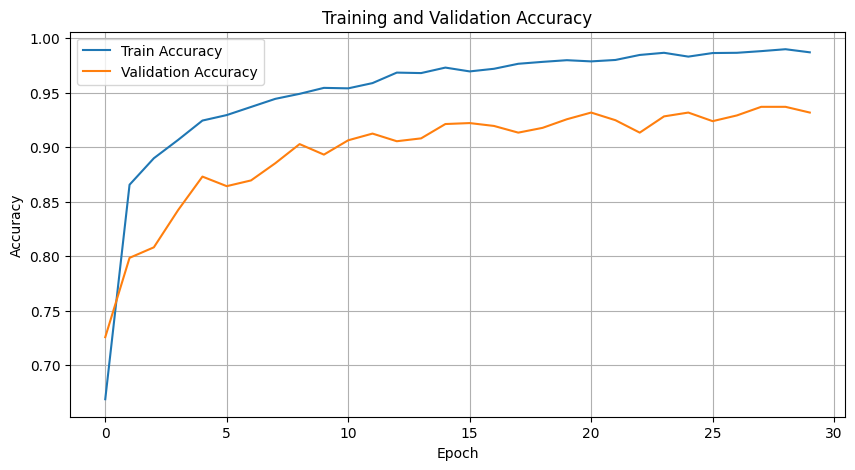

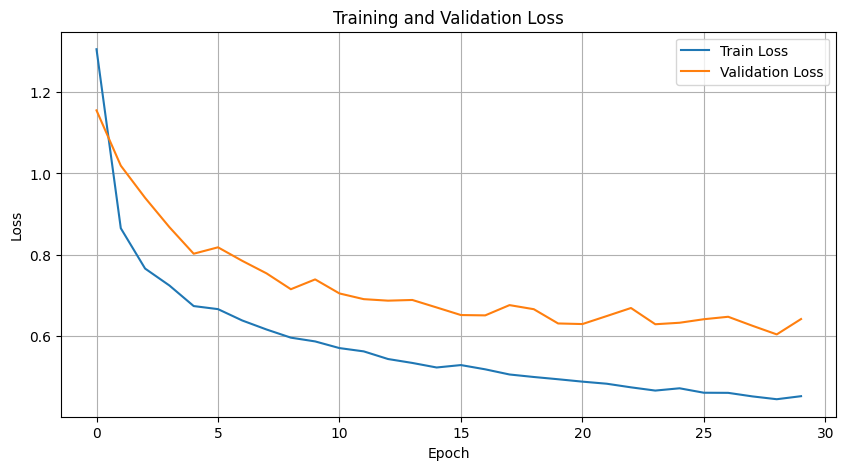

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Đọc file CSV chứa lịch sử huấn luyện
history_df = pd.read_csv('/content/drive/MyDrive/DACNTTNT/project/results/fine_tune_training_log.csv')

# Vẽ biểu đồ Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history_df['accuracy'], label='Train Accuracy')
plt.plot(history_df['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('/content/drive/MyDrive/DACNTTNT/project/results/fine_tune_accuracy_plot.webp', format='webp')
plt.show()

# Vẽ biểu đồ Loss
plt.figure(figsize=(10, 5))
plt.plot(history_df['loss'], label='Train Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('/content/drive/MyDrive/DACNTTNT/project/results/fine_tune_loss_plot.webp', format='webp')
plt.show()


36/36 ━━━━━━━━━━━━━━━━━━━━ 26s 722ms/step


<Figure size 1000x800 with 0 Axes>

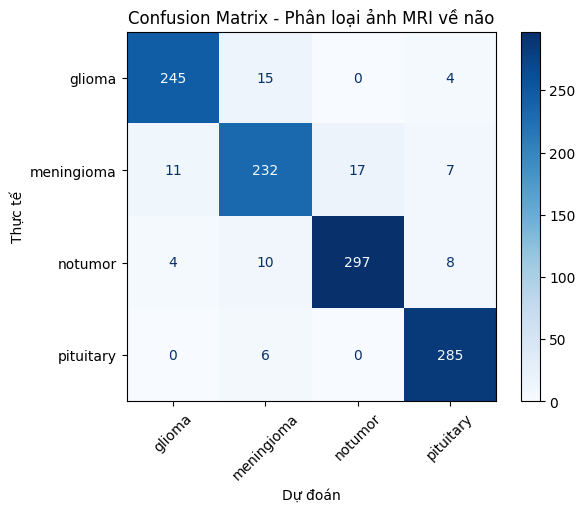

In [20]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred_probs = model.predict(validation_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

y_true = validation_generator.classes

class_names = list(validation_generator.class_indices.keys())

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
plt.figure(figsize=(10, 8))
disp.plot(cmap='Blues', values_format='d')
plt.xticks(rotation=45)
plt.title('Confusion Matrix - Phân loại ảnh MRI về não')
plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.show()

In [21]:
from PIL import Image

validation_img_paths = ["/content/drive/MyDrive/DACNTTNT/Brain_Tumor_Split/train/glioma/enh_Tr-glTr_0006.jpg",
                        "/content/drive/MyDrive/DACNTTNT/Brain_Tumor_Split/train/meningioma/enh_Tr-meTr_0009.jpg",
                        "/content/drive/MyDrive/DACNTTNT/Brain_Tumor_Split/train/notumor/enh_Tr-noTr_0008.jpg",
                        "/content/drive/MyDrive/DACNTTNT/Brain_Tumor_Split/train/pituitary/enh_Tr-piTr_0008.jpg",
                        "/content/drive/MyDrive/DACNTTNT/Brain_Tumor_Split/val/meningioma/enh_Tr-me_0012.jpg",
                        "/content/drive/MyDrive/DACNTTNT/Brain_Tumor_Split/val/glioma/enh_Tr-glTr_0000.jpg"]
img_list = [Image.open(img_path) for img_path in validation_img_paths]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


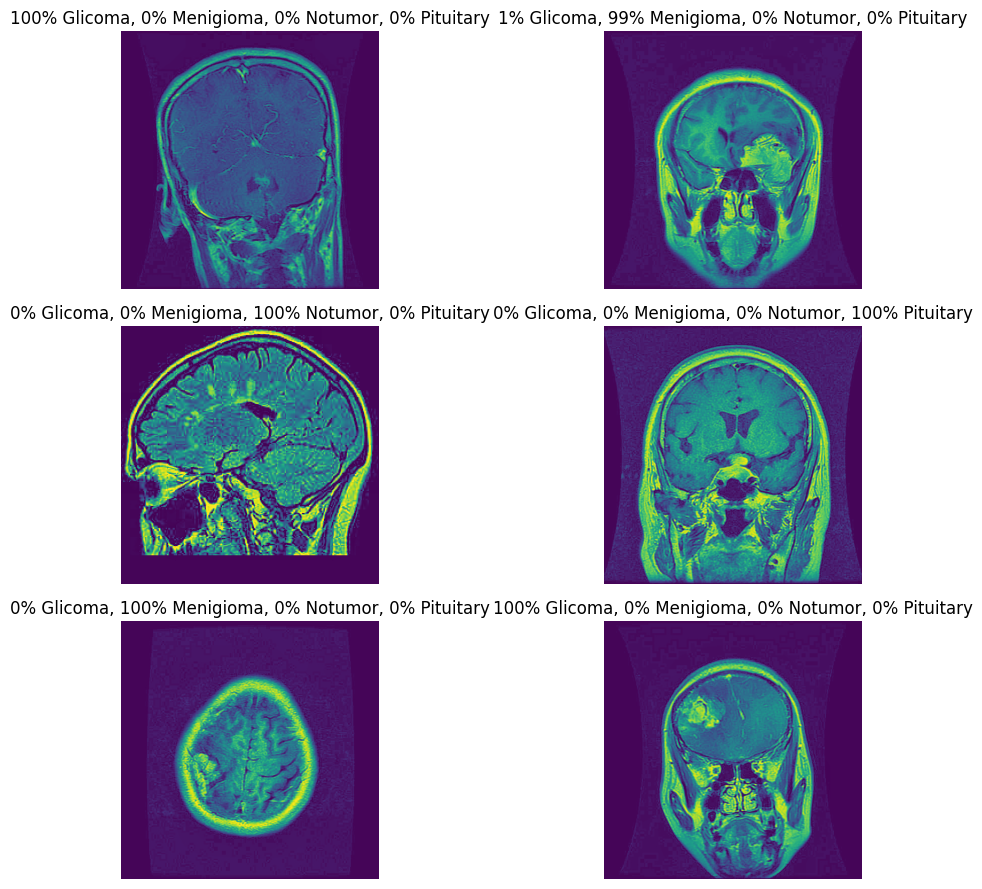

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import preprocess_input

# Resize ảnh, chuyển sang RGB, đưa vào batch
validation_batch = np.stack([
    preprocess_input(np.array(img.convert("RGB").resize((256, 256))))
    for img in img_list
])

# Dự đoán
pre_prob = model.predict(validation_batch)

# Vẽ ảnh và xác suất dự đoán
fig, axs = plt.subplots(3, 2, figsize=(12, 9))
axs = axs.flatten()
for i, img in enumerate(img_list):
  ax = axs[i]
  ax.axis('off')
  ax.set_title(
      "{:.0f}% Glicoma, {:.0f}% Menigioma, {:.0f}% Notumor, {:.0f}% Pituitary".format(
          100*pre_prob[i][0],
          100*pre_prob[i][1],
          100*pre_prob[i][2],
          100*pre_prob[i][3]
      )
  )
  ax.imshow(img)

plt.tight_layout()
plt.show()

So sánh với các thang đo khác để đánh giá mô hình dựa trên các chỉ số

In [23]:
import numpy as np

# Dự đoán xác suất
y_probs = model.predict(validation_generator)
# Chuyển sang nhãn dự đoán
y_pred = np.argmax(y_probs, axis=1)
# Nhãn thật từ generator
y_true = validation_generator.classes

36/36 ━━━━━━━━━━━━━━━━━━━━ 34s 950ms/step


In [24]:
from sklearn.metrics import classification_report
import pandas as pd

class_names = list(validation_generator.class_indices.keys())
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

      glioma       0.96      0.95      0.95       264
  meningioma       0.92      0.90      0.91       267
     notumor       0.94      0.94      0.94       319
   pituitary       0.94      0.97      0.95       291

    accuracy                           0.94      1141
   macro avg       0.94      0.94      0.94      1141
weighted avg       0.94      0.94      0.94      1141

